In [1]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec, KeyedVectors
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from numpy.linalg import norm

# Mi approach para este desafio va a ser usar word embedding. Voy a entrenar un modelo Word2Vec con los titulos de los item, y de esa forma representar los titulos como vectores para los cuales puedo medir distancias. Este approach me va a permitir ir mas alla que comparar las strings de los titulos con algun algoritmo como Levenshtein, pues puede explorar el contexto en donde las palabras en los titulos aparecen.

### Importamos la data y hacemos unas manipulaciones para que Word2Vec lo tome como input

In [2]:
df = pd.read_csv("Desafio ds 2022/items_titles.csv")
df_test = pd.read_csv("Desafio ds 2022/items_titles.csv")

In [3]:
df_test.head()

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Verme...
1,Tenis Para Caminhada Super Levinho Spider Corr...
2,Tênis Feminino Le Parc Hocks Black/ice Origina...
3,Tênis Olympikus Esportivo Academia Nova Tendên...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...


In [4]:
titulos = df_test["ITE_ITEM_TITLE"].values
titulos_vec = [nltk.word_tokenize(titulo) for titulo in titulos]

### Ahora voy a entrenar el modelo, y hay varios parametros para elegir. 

### Con respecto a la dimension del embedding, una dimension muy baja limitaria la diferenciacion que pueda hacer en el vocabulario, y una dimension muy grande podria llevarnos a un derroche de recursos. Leyendo en la literatura del tema, una dimension de entre 100-300 suele ser suficientemente buena. 

### Con respecto el window size, este parametro controla cuanto del contexto de una palabra en uno de los titulos tengo en cuenta al entrenar el modelo. Un window size grande va a tener en cuenta todas las palabras que aparecen en el titulo, mientras que un window size mas bajo me puede informar mejor acerca de la funcionalidad de las palabras en las oraciones ( cuales son usadas como sinonimos o pueden remplazarse entre si). Para encontrar similitud entre los titulos, voy a elegir un window size que practicamente tiene en cuenta todo el contexto de las palabras.

### Despues esta el parametro sg, que controla que que tipo de modelo Word2Vec usamos ( Continuous Bag Of Words o skim-gram) 

In [5]:
dim = 200
model = Word2Vec(window = 10, min_count = 10, sg = 1, vector_size = dim)
model.build_vocab(titulos_vec, progress_per = 2000)
model.train(titulos_vec, total_examples = model.corpus_count,epochs = model.epochs)

(659395, 1100765)

### Hechemos un vistazo a las asociaciones que mi modelo ha hecho con algunas palabras

In [6]:
word_vectors = model.wv
model.wv.most_similar('Tv'), model.wv.most_similar('Ciclismo'),model.wv.most_similar('Tênis')


([('Polegadas', 0.9630606174468994),
  ('Samsung', 0.9542667269706726),
  ('LG', 0.9463794827461243),
  ('Sony', 0.9361445307731628),
  ('Philips', 0.9320946335792542),
  ('Tela', 0.9300855398178101),
  ('Lcd', 0.9298710823059082),
  ('Defeito', 0.9284782409667969),
  ('Quebrada', 0.9263912439346313),
  ('Hdr', 0.9256733655929565)],
 [('Clip', 0.9612801671028137),
  ('Ciclista', 0.9528791904449463),
  ('Bontrager', 0.9414955377578735),
  ('Giro', 0.9384506940841675),
  ('Ttr', 0.9337477087974548),
  ('Mattos', 0.9289796352386475),
  ('Boa', 0.9252724051475525),
  ('Rincon', 0.9208957552909851),
  ('Grool', 0.9194552302360535),
  ('Mia', 0.9165037870407104)],
 [('Tenis', 0.731685996055603),
  ('Bordô', 0.6535816788673401),
  ('Mescla', 0.6366185545921326),
  ('Dom', 0.631696879863739),
  ('Liquidação', 0.6120774745941162),
  ('C/nota', 0.6086826324462891),
  ('Lojas', 0.6046314239501953),
  ('Candy', 0.604141116142273),
  ('Jogging', 0.6036765575408936),
  ('Branco/preto', 0.60320276021

### Cada palabra que aparece en los titulos ahora esta representada por un vector de dimension 200. Para representar un titulo, que es una coleccion de palabras, podria hacer un average de los vectores que representan a sus palabras.

In [7]:
def vectorizer(sent,m):
    vec = []
    numw = 0
    for w in sent:
        try:
            if numw ==0:
                vec = m[w]
            else:
                vec = np.add(vec, m[w])
            numw += 1
        except:
            pass
        
    return np.asarray(vec)/numw
X = np.zeros((len(titulos_vec), dim))
excluded = []
for i in np.arange(len(titulos_vec)):
    #Deshagamonos de los titulos que no pueden ser representados en el embedding
    if (vectorizer(titulos_vec[i],word_vectors).shape[0]) != dim:
        excluded.append(i)
        continue
    else:
        X[i,:] = vectorizer(titulos_vec[i],word_vectors)


### Vamos a chequear que algunos titulos han sido mapeados a cero y que esos elementos representan titulos con palabras mas "perdidas" o sin buen contexto.

In [8]:
X[excluded,:], X[excluded,:].shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (35, 200))

In [9]:
df_test.loc[excluded]

,ITE_ITEM_TITLE
32,Lubrificante Lube Cera 25g
513,Sansumg Ln46n81 Tcom
1347,Airforce
2057,Bmc Tm01
3714,Giuseppe Zanotti Frankie 38br
5031,Rs-x3 Olympic
5468,Sapatofk
5964,Grendha
6143,Sapato/tênis Salvatore Ferragamo
6552,But


### Efectivamente podemos ver que muchos de los titulos que hemos mapeado a cero eran palabras sueltas o titulos vagos o porqueria.

### En principio, podria ya ir y usar los vectores que representan los titulos y tomar su cosine_similarity para ver cuan cercanos son. Antes que eso, me gustaria analizar un poco mas que es lo que ha hecho mi modelo. Algo que podemos tratar de ver es si hay clusters de titulos parecidos y si hay una diferencia notable de los productos que estos clusters representan. Podemos analizar los clusters usando KMeans. Primero , usamos el Elbow methods para descubrir o sugerir un numero de clusters.

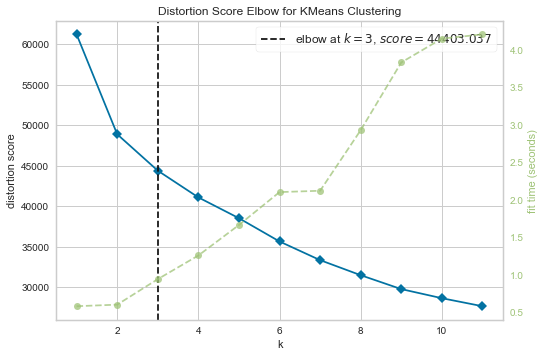

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(X)
visualizer.show()

### Encontramos que el numero sugerido de clusters es 3. Usando eso, podemos dar predicciones para el cluster al que corresponde cada titulo.

In [11]:
n_clusters = 3
clf = KMeans(n_clusters = n_clusters, max_iter = 100, init = 'k-means++', n_init = 1)
labels = clf.fit_predict(X)

### Una forma de poder visualizar los la distribucion de estos clusters es hacer hacer una analisis de componentes principales. Por ejemplo, debajo graficamos las coordenadas de los titulos en terminos de las dos primeras componentes principales. Con colores distintos diferenciamos titulos pertenecientes a distintos clusters.

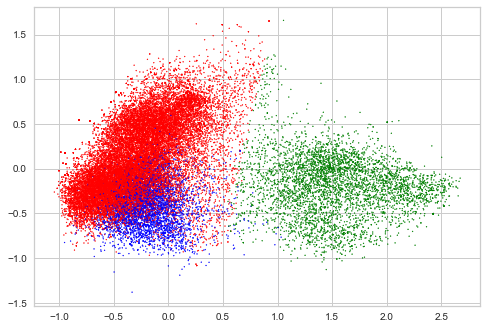

In [12]:
pca = PCA(n_components = n_clusters).fit(X)
coords = pca.transform(X)
label_colors = ["blue","red","green"]
colors = [label_colors[i] for i in labels]
plt.scatter(coords[:,0], coords[:,1], c = colors, s = 1)
plt.show()

### Interesante! Podemos ver que claramente el modelo captura agrupamiento de titulos. Miremos nosotros mismos que tipo de titulos han sido agrupados por el modelo.

In [13]:
df_test['CLUSTER'] = labels

In [14]:
df_test.loc[df_test.CLUSTER == 0] 

,ITE_ITEM_TITLE,CLUSTER
6,Tênis Infantil Ortopasso Conforto Jogging,0
11,Sapatenis Casual Combo 3 Pares Infantil Dex,0
14,Tênis Molekinha Chunky Flatform Infantil Sem C...,0
15,Tênis Infantil Feminino Kidy Hype Nude,0
42,Tenis De Menino Bota Com Luz De Led Sapato Pre...,0
...,...,...
29953,Tênis Menino Menina Infantil Escolar Audax A24...,0
29954,Tenis Calce Facil Infantil Feminino E Masculin...,0
29960,Tênis Infantil Sem Cadarço Bibi Roller Newrln-...,0
29966,Tenis Botinho Infantil Cano Alto - B677 Novo,0


In [15]:
df_test.loc[df_test.CLUSTER == 1]

,ITE_ITEM_TITLE,CLUSTER
0,Tênis Ascension Posh Masculino - Preto E Verme...,1
1,Tenis Para Caminhada Super Levinho Spider Corr...,1
2,Tênis Feminino Le Parc Hocks Black/ice Origina...,1
3,Tênis Olympikus Esportivo Academia Nova Tendên...,1
5,Tênis Casual Masculino Zarato 941 Preto 632,1
...,...,...
29994,Air Force Shadow Mystic Navy,1
29995,Tênis Vans Old Skool I Love My Vans - Usado - ...,1
29996,Tênis Feminino Preto Moleca 5296155,1
29997,Tenis Botinha Com Pelo Via Marte Original Lanç...,1


In [16]:
df_test.loc[df_test.CLUSTER == 2]

,ITE_ITEM_TITLE,CLUSTER
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...,2
7,Tv Samsung Qled 8k Q800t Semi Nova,2
10,Sapatilha Bike Absolute Nero Mtb Para Pedal Cl...,2
16,Bicicleta Masculina Com Aro 24 Com Nf,2
18,Smart Tv Led 40 Philco Ptv40e60sn Full Hd Conv...,2
...,...,...
29958,Tv 42 Pol Led LG,2
29974,Tv Semp-toshiba 10 - Antiga - Sucata,2
29978,Fucsia Aro 12 Bicicleta - 10440,2
29983,Smart Tv LG 65 4k Nanocell 65nano75 Hdmi Ai Pr...,2


### Bien, puedo observar lo siguiente. Ya con el grafico se podia ver que el cluster verde estaba bastante diferenciado de los clusters azul y rojos (que bien podrian ser cosiderados un solo gran cluster). El cluster verde ha capturado mayoritariamente titulos relacionados a ciclismo, bicicletas y televisores. Los cluster azul y rojo ambos parecieran corresponder a calzado. 

### Uno podria preguntarse porque KMeans no ha separado los clusters de manera distinta, por ejemplo, calzados, ciclismos y Tvs. Tal vez sea porque hay menos titulos relacionados a Tvs y muchos relacionados a calzados, que KMeans priorizo diferencias intra-calzados. 

### Por un lado, esta inspeccion nos muestra que el modelo ha logrado asociar titulos de una manera que tiene sentido, pero podria preocuparnos que bicicletas y Tvs hayan sido consideradas parte del mismo cluster por KMeans. Para ver si podemos sacarnos algo de preoocupacion, podemos ir al cluster verde y ver si la cosine_similarity de titulos tipo bicicleta y tipo TV refleja la diferencia de los titulos.

In [23]:
df_test.loc[df_test.CLUSTER == 2]

,ITE_ITEM_TITLE,CLUSTER
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...,2
7,Tv Samsung Qled 8k Q800t Semi Nova,2
10,Sapatilha Bike Absolute Nero Mtb Para Pedal Cl...,2
16,Bicicleta Masculina Com Aro 24 Com Nf,2
18,Smart Tv Led 40 Philco Ptv40e60sn Full Hd Conv...,2
...,...,...
29958,Tv 42 Pol Led LG,2
29974,Tv Semp-toshiba 10 - Antiga - Sucata,2
29978,Fucsia Aro 12 Bicicleta - 10440,2
29983,Smart Tv LG 65 4k Nanocell 65nano75 Hdmi Ai Pr...,2


In [24]:
def cos_sim(A,B):
    
    dot = np.dot(A,B)
    
    if dot == 0:
        return 0
    else:  
        return np.dot(A,B)/(norm(A)*norm(B))

### Por ejemplo, veamos cuan similares son dos titulos tipo bicicleta, dos titulos tipo Tv, y la mezcla.

In [25]:
cos_sim(X[16],X[29999]), cos_sim(X[7],X[29974]), cos_sim(X[7],X[29999])

(0.854243549562592, 0.8201099526601028, 0.4536769930114784)

In [26]:
cos_sim(X[16],X[29978]), cos_sim(X[7],X[29958]), cos_sim(X[29978],X[29958])

(0.8400274598050357, 0.9681917741580023, 0.41790131136161995)

### Vemos que, a pesar de haber sido asignados al mismo cluster, la diferencia entre titulos tipo bicicleta y tipo Tv es capturada de buena manera por la representacion vectorial.

### Finalmente, sabiendo que nuestro modelo ha logrado generar representaciones para los titulos que capturan su contexto y algun tipo de sentido, podemos armar una funcion que tome un set de titulos del data set, y construya la tabla de similitudes.

In [31]:
def tabla_sim(idxs):
    
    pairs = [(i, j) for i in idxs for j in idxs if (i != j and i < j )]
    
    
    df_sim = pd.DataFrame(columns=['ITEM_TITLE_1', 'ITEM_TITLE_2', 'Score Similitud (0,1)'],
                  index=range(len(pairs)))
    
    for i in np.arange(len(pairs)):
        df_sim['ITEM_TITLE_1'].iloc[i] = df_test['ITE_ITEM_TITLE'].iloc[pairs[i][0]]
        df_sim['ITEM_TITLE_2'].iloc[i] = df_test['ITE_ITEM_TITLE'].iloc[pairs[i][1]]
        df_sim['Score Similitud (0,1)'].iloc[i] = cos_sim(X[pairs[i][0]],X[pairs[i][1]])
    
    df_sim.sort_values('Score Similitud (0,1)',inplace = True,ascending = False)
    
    return df_sim

### Veamos por ejemplo, los titulos mas similares entre los primeros 200 titulos

In [32]:
tabla_sim([i for i in range(200)] )

,ITEM_TITLE_1,ITEM_TITLE_2,"Score Similitud (0,1)"
1694,Tênis Usthemp Short Temático - Maria Vira-lata 2,Tênis Usthemp Short Temático - Borboleta 2,0.998012
7814,Tênis Masculino Esportivo Actvitta 4907.101,Tênis Actvitta Esportivo Masculino 4908.204 Pr...,0.991941
3581,Smart Tv Led 40 Philco Ptv40e60sn Full Hd Conv...,Tv Digital Portátil 14 Polegadas Led Monitor H...,0.991724
12775,Bicicleta Nathor Aro 12 Infantil Cores Masculi...,Bicicleta Aro 12 Feminina Infantil Nathor Viol...,0.991321
17081,Bicicleta Aro 29 Rs1 Pro 24v Freio Hidra Trava...,Bicicleta Gts Pro M5 Techs 21v Aro 29 Freio À ...,0.989959
...,...,...,...
6027,Lubrificante Lube Cera 25g,Tênis Sapato Short Bermuda Combo Promoção Lanç...,0
5962,Lubrificante Lube Cera 25g,Tenis Mustique Rsv #247 Reserva - Marrom,0
5963,Lubrificante Lube Cera 25g,Bicicleta Aro 29 Rs1 Pro 24v Freio Hidra Trava...,0
6026,Lubrificante Lube Cera 25g,Bicicleta Aro 26 Caloi Andes V-brake 21 Marcha...,0
